In [ ]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt


import pmdarima as pm
import statsmodels as st

from utils_time_series import *

In [ ]:
ticker = "AAPL"
using_papermill = False

In [ ]:
if not using_papermill:
    %load_ext autoreload
    %autoreload 2
    stocks = {}
    for file in os.listdir("stocks"):
        if ".parquet" in file:
            stock_name = file.rstrip(".parquet")
            df = pd.read_parquet(f"stocks/{file}")
            stocks[stock_name] = df
    print(stocks.keys())
    
    df = stocks[ticker]
else:
    df = pd.read_parquet(f"stocks/{ticker}.parquet")
    

In [ ]:
df_raw = df.copy()

df["Close_diff"] = df.Close.diff(1)
df = (df.set_index("date")
        .asfreq("D")
        .ffill()
        .bfill()
     )
#we fill saturdays and sundays with friday values

In [ ]:
fig, ax = plt.subplots(figsize = (20, 5))
sns.lineplot(data = df, x = "date", y = "Close", color="blue", label=ticker, linestyle="-")
sns.lineplot(data = df, x = "date", y = "High", color="red", linestyle="dashed")
sns.lineplot(data = df, x = "date", y = "Low",  color="red", linestyle="dashed")


### Check for stationarity

In [ ]:
stationary_test = pm.arima.ADFTest()
stationary_test.should_diff(df.Close)

In [ ]:
first_diff = df.Close.diff(periods = 1).dropna()
print(stationary_test.should_diff(first_diff))

fig, ax = plt.subplots(figsize = (20, 5))
sns.lineplot(data = first_diff, label=ticker, linestyle="-")


### Autocorrelation and partial-autocorrelation
* acf is used to determine MA order
* pacf is used to determine AR order

https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c#:~:text=The%20difference%20between%20ACF%20and,indicator%20of%20the%20significance%20threshold.

In [ ]:
acf_p_values = pm.acf(first_diff)
pacf_p_values = pm.pacf(first_diff, method = "ols")

p_values_df = pd.DataFrame({"acf" : acf_p_values, "pacf" : pacf_p_values}).round(2)

In [ ]:
(p_values_df[
    (p_values_df > 0.05).any(axis = 1)
].T
 .style
 .background_gradient(axis = None)
 .format(precision =2)
)

Figure(1080x720)
Figure(1080x720)


/Users/juanluis/opt/anaconda3/envs/tfm/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


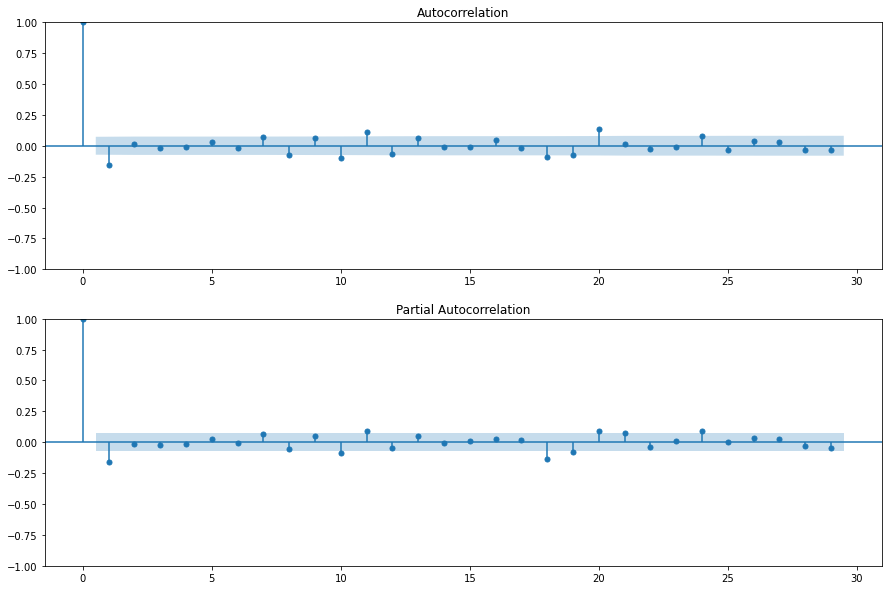

In [397]:
#first_diff = df.Close.diff(7).dropna()
fig, axes = plt.subplots(2,1, figsize = (15,10))
print(st.graphics.tsaplots.plot_acf(first_diff, ax = axes[0]))
print(st.graphics.tsaplots.plot_pacf(first_diff, ax = axes[1]))

In [398]:
errors = {}
threshold = '2020-09-30 23:59:00'

train_df, test_df = train_test_split(df, threshold, )#train_pctg = 0.85)


In [399]:
forecaster = fit_arima_model(train_df, exog_cols = None)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2336.766, Time=0.28 sec
First viable model found (2336.766)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2341.391, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2331.651, Time=0.03 sec
New best model found (2331.651 < 2336.766)
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2331.011, Time=0.03 sec
New best model found (2331.011 < 2331.651)
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2343.377, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2332.798, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2332.812, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2334.798, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2334.450, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.638 seconds


In [400]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  639
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1162.505
Date:                Thu, 27 Apr 2023   AIC                           2331.011
Time:                        19:22:19   BIC                           2344.386
Sample:                    01-01-2019   HQIC                          2336.203
                         - 09-30-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1194      0.051      2.320      0.020       0.019       0.220
ma.L1         -0.1426      0.026     -5.394      0.000      -0.194      -0.091
sigma2         2.2396      0.045     49.480      0.000       2.151       2.328
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5132.05
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):              12.76   Skew:                            -0.59
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Test error (rmse): 2.0792709932157094


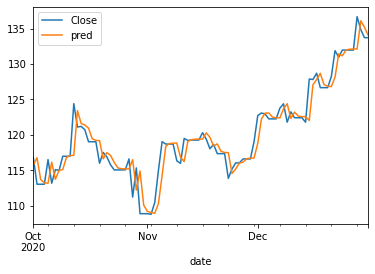

In [401]:
pred_df = predict_arima_ahead_update(forecaster, test_df, exog_cols = None)
errors["rsme_arima_close"] = compute_test_error(pred_df)

The arima model is clearly predicting the value of the previous day.

Lets see if we can add some exogenous variables from the news data

Test error (rmse): 2.3595054271527944
Test error (rmse): 4.806295636362065


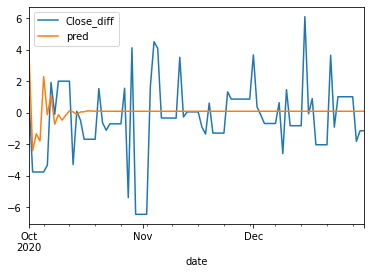

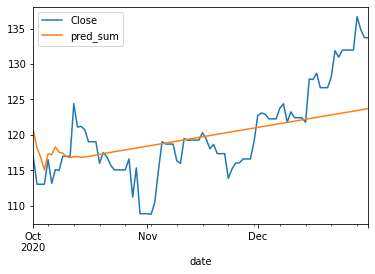

In [402]:
gb_forecaster = fit_model(train_df, target_col="Close_diff", exog_cols = None)
pred_df = predict_ahead(gb_forecaster, test_df, exog_cols = None)
pred_df["pred_sum"] = pred_df["pred"].cumsum() + pred_df.iloc[0].Close
errors["rsme_gb_close_diff"] = compute_test_error(pred_df, y_pred_col = "pred",     y_true_col = "Close_diff")
errors["rsme_gb_close"] = compute_test_error(pred_df, y_pred_col = "pred_sum", y_true_col = "Close")



## Exogenous variables

In [403]:
def best_sentiment_score_lags(df, ticker, num_lags = 30, corr_threshold = 0.1):
    df = df.copy()
    for i in range(0,num_lags):
        df[f"tails_score_lag_{i}"] = df.tails_median_score.shift(i)
    tails_lag_corr = df.corr()[["Close"]].iloc[3:]
    
    fig, ax = plt.subplots(figsize = (10,5))

    tails_lag_corr.plot(ax = ax, title = f"Cross correlation with lagged tails sentiment score: {ticker}")
    plt.xticks(rotation=45)
    plt.show()
    return tails_lag_corr[(tails_lag_corr.abs() > corr_threshold).values]
    
    


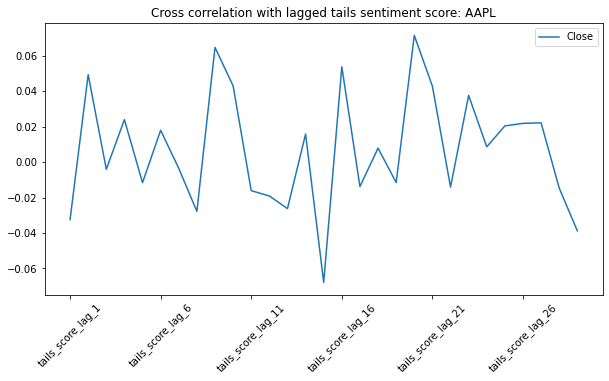

In [404]:


tails_df = train_df[["Close", "tails_median_score"]].copy()
tails_df.Close = tails_df.Close.diff(1) #we differenciate

# We compute the correlation of the change in the close value with the sentiment score at different lags.
# This way we detect how news correlate with change and how many days does it take to make this change
tails_lag_corr = best_sentiment_score_lags(tails_df, ticker, corr_threshold= 0.06)

In [405]:
tails_lag_corr

,Close
tails_score_lag_9,0.064646
tails_score_lag_15,-0.067918
tails_score_lag_20,0.071437


In [406]:
for feature in tails_lag_corr.index:
    lag_value = int(feature.split("_")[-1])
    df[feature] = df.tails_median_score.shift(lag_value)

In [407]:
exog_cols = tails_lag_corr.index.values.tolist() + ["tails_median_score"]

train_df, test_df = train_test_split(df, threshold, )#train_pctg = 0.85)
train_df = train_df.dropna(subset = exog_cols) # we drop the first rows in training where we dont have data.

Test error (rmse): 2.076757931720012
Exog cols : ['tails_score_lag_9', 'tails_score_lag_15', 'tails_score_lag_20', 'tails_median_score']


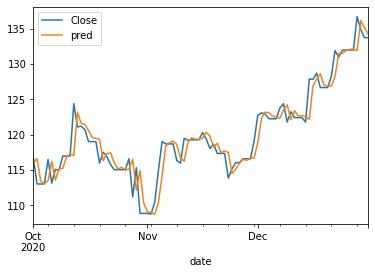

In [408]:
model = pm.arima.ARIMA(order = forecaster.order, suppress_warnings = True)
forecaster = model.fit(train_df.Close, X = train_df[exog_cols])
#forecaster = fit_arima_model(train_df, exog_cols = exog_cols)
pred_df = predict_arima_ahead_update(forecaster, test_df, exog_cols = exog_cols)
errors["rsme_arima_close_exog"] = compute_test_error(pred_df, y_true_col="Close", exog_cols = exog_cols)

Test error (rmse): 2.5839576235709822
Test error (rmse): 13.994190441968575


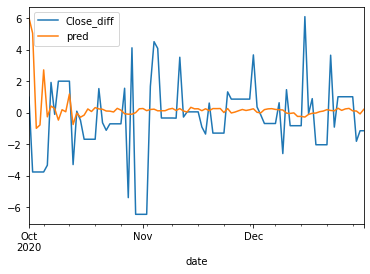

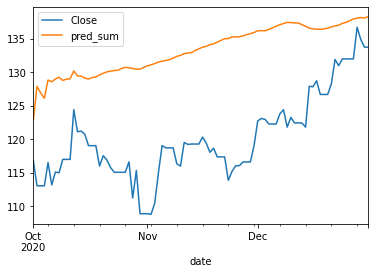

In [409]:
gb_forecaster = fit_model(train_df, target_col="Close_diff", exog_cols = exog_cols)
pred_df = predict_ahead(gb_forecaster, test_df, exog_cols = exog_cols)
pred_df["pred_sum"] = pred_df["pred"].cumsum() + pred_df.iloc[0].Close
errors["rsme_gb_close_diff_exog"] = compute_test_error(pred_df, y_pred_col = "pred",     y_true_col = "Close_diff")
errors["rsme_gb_close_exog"] = compute_test_error(pred_df, y_pred_col = "pred_sum", y_true_col = "Close")



In [414]:
errors

{'rsme_arima_close': 2.0792709932157094,
 'rsme_gb_close_diff': 2.3595054271527944,
 'rsme_gb_close': 4.806295636362065,
 'rsme_arima_close_exog': 2.076757931720012,
 'rsme_gb_close_diff_exog': 2.5839576235709822,
 'rsme_gb_close_exog': 13.994190441968575}

In [415]:

print("Is exog better?",errors["rsme_arima_close"] > errors["rsme_arima_close_exog"])

Is exog better? True


# Borrador

In [231]:
raw = df_raw[["Close", "tails_median_score"]].copy()

In [232]:
raw["Close_diff"] = raw.Close.diff(1)

In [233]:
q1, q3 = df.Close_diff.quantile([0.25, 0.75]).values

def growth(x):
    if x >= q3:
        return 1
    elif x <= q1:
        return -1
    else:
        return 0

In [333]:
raw["stock_growth"] = raw.Close_diff.apply(growth)

In [235]:
from sklearn.cluster import KMeans

In [297]:
scores = raw.tails_median_score
CLUSTERS = 3
if scores.isna().any():
    CLUSTERS+=1
    nan_value = scores.max() + (scores.max() - scores.min())*100
    scores =scores.fillna(nan_value)
data = scores.values.reshape(-1,1)
preds = KMeans(CLUSTERS).fit_predict(data)

In [319]:
kmeans_df = pd.DataFrame({"score" : scores, "cluster" : preds})

In [320]:
kmeans_df = kmeans_df.where(kmeans_df.score != nan_value, None)

In [325]:
cluster_indices = kmeans_df.groupby("cluster").mean().sort_values("score").index.values
cluster_mapping = { assigned_cluster: real_cluster for real_cluster, assigned_cluster in zip(range(CLUSTERS),cluster_indices)}

In [332]:
raw["sentiment_growth"] = kmeans_df.cluster.apply(cluster_mapping.get) - 1

In [335]:
from sklearn.metrics import confusion_matrix

In [350]:
growth_df = (raw[["sentiment_growth", "stock_growth"]]
             .dropna()
             .astype(int))

In [355]:
growth_df.sentiment_growth.value_counts()

 1    293
-1    272
 0    127
Name: sentiment_growth, dtype: int64

In [353]:
(growth_df.sentiment_growth == growth_df.stock_growth).sum() / len (growth_df)

0.27167630057803466

In [361]:
from sklearn.metrics import accuracy_score

In [368]:
#growth_df[growth_df.stock_growth != 0]

,sentiment_growth,stock_growth
2,-1,-1
3,-1,1
14,0,1
24,0,1
29,-1,1
...,...,...
717,-1,-1
721,-1,1
722,-1,-1
723,1,1
